In [11]:
##https://github.com/moskomule/ewc.pytorch
import matplotlib.pyplot as plt

plt.style.use("seaborn-white")
import pickle
import random
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from tqdm import tqdm

from data_loader import WeatherData
from extra_dataloader import NewWeatherData
from models.lstm_ff import LSTM_FF
from utils import EWC, ewc_train, normal_train, test


In [12]:
manual_seed = 555
random.seed(manual_seed)
torch.manual_seed(manual_seed)

epochs = 15
lr = 0.00001
batch_size = 128
sample_size = 200
hidden_size = 128
num_task = 3
sequence_len = 7

In [13]:
def get_dataloader():
    path = 'data/'
    train_loader = {}
    test_loader = {}
    #MSFT data
    train_loader[0] = (torch.utils.data.DataLoader(WeatherData(path+'PARSED_NW_Ground_Stations_2016.csv', 'daily_precip', sequence_len),batch_size=batch_size,num_workers=4))
    test_loader[0] = (torch.utils.data.DataLoader(WeatherData(path+'PARSED_NW_Ground_Stations_2017.csv', 'daily_precip', sequence_len),batch_size=batch_size))

    #NKE data
    train_loader[1] = (torch.utils.data.DataLoader(WeatherData(path+'PARSED_NW_Ground_Stations_2016.csv', 'winddir', sequence_len),batch_size=batch_size,num_workers=4))
    test_loader[1] = (torch.utils.data.DataLoader(WeatherData(path+'PARSED_NW_Ground_Stations_2017.csv', 'winddir', sequence_len),batch_size=batch_size))

    
    train_loader[2] = (torch.utils.data.DataLoader(NewWeatherData(path+'new_train_weather_data.csv', 'rain', sequence_len),batch_size=batch_size,num_workers=4))
    test_loader[2] = (torch.utils.data.DataLoader(NewWeatherData(path+'new_test_weather_data.csv', 'rain', sequence_len),batch_size=batch_size))

    return train_loader, test_loader


train_loader, test_loader = get_dataloader()


d:\Work\Uni Work\MSc Project\Deployment\precip_prediction\data_loader.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.targets[idx] = 0
d:\Work\Uni Work\MSc Project\Deployment\precip_prediction\data_loader.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.targets[idx] = 1
d:\Work\Uni Work\MSc Project\Deployment\precip_prediction\data_loader.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.targets[idx] = 1


0    13851
1     3822
Name: daily_precip, dtype: int64
0    14000
1     3757
Name: daily_precip, dtype: int64


d:\Work\Uni Work\MSc Project\Deployment\precip_prediction\data_loader.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.targets[idx] = 1
d:\Work\Uni Work\MSc Project\Deployment\precip_prediction\data_loader.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.targets[idx] = 0


1    9687
0    7986
Name: winddir, dtype: int64
1    10591
0     7166
Name: winddir, dtype: int64


d:\Work\Uni Work\MSc Project\Deployment\precip_prediction\extra_dataloader.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.targets[idx] = 1
d:\Work\Uni Work\MSc Project\Deployment\precip_prediction\extra_dataloader.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.targets[idx] = 0


1    8898
0    1102
Name: rain, dtype: int64
1    1832
0     168
Name: rain, dtype: int64


In [14]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

in_features = 5
loss_weights = [torch.Tensor([0.3,1]).to(device), torch.Tensor([1, 0.95]).to(device), torch.Tensor([1, 0.15]).to(device)]


In [15]:
def standard_process(epochs, use_cuda=True, weight=True):
    model = LSTM_FF(in_features, hidden_size, 2, sequence_len,batch_first=True, bidirectional=False).to(device)
    optimizer = optim.Adam(params=model.parameters(), lr=lr)

    loss, acc,li_class_matrix = {}, {}, {0:[], 1:[], 2:[]}
    for task in range(num_task):
        loss[task] = []
        acc[task] = []
        for _ in tqdm(range(epochs)):
            loss[task].append(normal_train(model, optimizer, train_loader[task], loss_weights[task]))
            for sub_task in range(task + 1):
                acc_, class_matrix =  test(model, test_loader[sub_task])
                acc[sub_task].append(acc_)
                li_class_matrix[sub_task].append(class_matrix)
        if task == 0 and weight:
            weight = model.state_dict()

    return loss, acc, weight, li_class_matrix


def ewc_process(epochs, importance, use_cuda=True, weight=None):
    model = LSTM_FF(in_features, hidden_size, 2, sequence_len,batch_first=True, bidirectional=False).to(device)
    optimizer = optim.Adam(params=model.parameters(), lr=lr)

    loss, acc,li_class_matrix = {}, {}, {0:[], 1:[], 2:[]}
    for task in range(num_task):
        loss[task] = []
        acc[task] = []

        if task == 0:
            if weight:
                model.load_state_dict(weight)
            else:
                for _ in tqdm(range(epochs)):
                    loss[task].append(normal_train(model, optimizer, train_loader[task], loss_weights[task]))
                    acc_, class_matrix =  test(model, test_loader[task])
                    acc[task].append(acc_)
                    li_class_matrix[task].append(class_matrix)
        else:
            old_tasks = []
            for sub_task in range(task):
                old_tasks = old_tasks + train_loader[sub_task].dataset.get_sample(sample_size)
            old_tasks = random.sample(old_tasks, k=sample_size)
            for _ in tqdm(range(epochs)):
                loss[task].append(ewc_train(model, optimizer, train_loader[task], EWC(model, old_tasks), importance, loss_weights[task]))
                for sub_task in range(task + 1):
                    acc_, class_matrix =  test(model, test_loader[sub_task])
                    acc[sub_task].append(acc_)
                    li_class_matrix[sub_task].append(class_matrix)
    weight = model.state_dict()
    return loss, acc, weight,li_class_matrix


In [16]:
def loss_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, (t + 1) * epochs)), v)

def accuracy_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, num_task * epochs)), v)
    plt.ylim(0, 1)

In [ ]:
loss, acc, weight, retro_acc = standard_process(epochs)

100%|██████████| 15/15 [01:47<00:00,  7.14s/it]


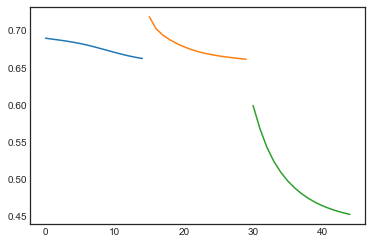

In [ ]:
loss_plot(loss)

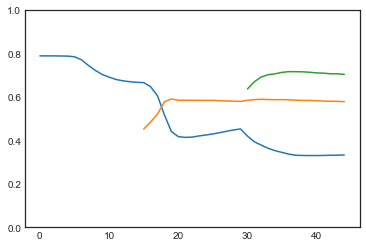

In [ ]:
accuracy_plot(acc)

In [ ]:
loss_ewc, acc_ewc,retro_acc_ewc = ewc_process(epochs, importance=100, 
#                                 weight=weight
                               )
loss_ewc2m, acc_ewc2, retro_acc_ewc = ewc_process(epochs, importance=1000000)

100%|██████████| 15/15 [02:00<00:00,  8.01s/it]


In [18]:
for i in range(7,9,1):
   loss, acc, weight, li_class_matrix = standard_process(epochs)
   with open("results/30_EPOCH_STANDARD"+str(i), 'wb') as f:
      data = {'loss':loss, 'acc':acc, 'weight':weight, 'class_matrix':li_class_matrix}
      pickle.dump(data, f)
   torch.save(weight, 'results/saved_nets/30_EPOCH_VAE_FIXED_StandardProcess_'+str(i)+"MLP_WEIGHTS")


   
   loss_ewc, acc_ewc, weights,li_class_matrix = ewc_process(epochs, importance=1000000)
   with open("results/30_EPOCH_EWC"+str(i), 'wb') as f:
      data = {'loss_ewc':loss_ewc,'acc_ewc':acc_ewc,'class_matrix':li_class_matrix}
      pickle.dump(data, f)
   torch.save(weights, 'results/saved_nets/30_EPOCH_VAE_FIXED_EWC_'+str(i)+"MLP_WEIGHTS")

100%|██████████| 15/15 [03:08<00:00, 12.57s/it]


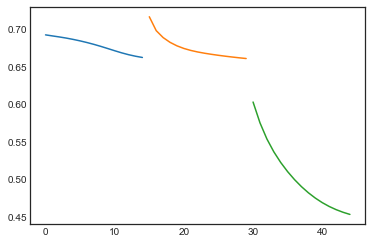

In [ ]:
loss_plot(loss_ewc)

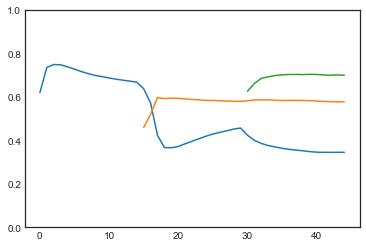

In [ ]:
accuracy_plot(acc_ewc)

In [ ]:
accuracy_plot(acc_ewc2)

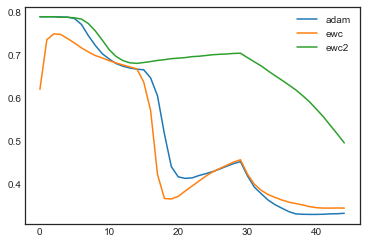

In [ ]:
plt.plot(acc[0], label="adam")
plt.plot(acc_ewc[0], label="ewc")
plt.plot(acc_ewc2[0], label="ewc2")
plt.legend()

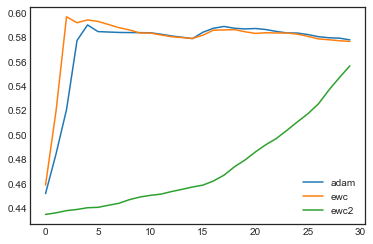

In [ ]:
plt.plot(acc[1], label="adam")
plt.plot(acc_ewc[1], label="ewc")
plt.plot(acc_ewc2[1], label="ewc2")
plt.legend()

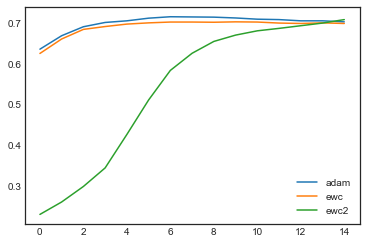

In [ ]:
plt.plot(acc[2], label="adam")
plt.plot(acc_ewc[2], label="ewc")
plt.plot(acc_ewc2[2], label="ewc2")
plt.legend()

In [ ]:
print(retro_acc, retro_acc_ewc)

[tensor(0.3327, device='cuda:0'), tensor(0.5779, device='cuda:0'), tensor(0.7035, device='cuda:0')] [tensor(0.4959, device='cuda:0'), tensor(0.5566, device='cuda:0'), tensor(0.7090, device='cuda:0')]
